In [1]:
import os
def get_api_key(api_key_name):
    return os.getenv(api_key_name)

In [2]:
from typing import Annotated, TypedDict, Literal
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
import requests
from langchain.utilities import SerpAPIWrapper
from langchain.prompts import PromptTemplate

In [3]:
from dotenv import find_dotenv, load_dotenv
load_dotenv(find_dotenv())
google_api = get_api_key("GOOGLE_API_KEY")
serp_api = get_api_key("SERPAPI_API_KEY")
weather_api = get_api_key("OPENWEATHERMAP_API_KEY")

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0.3, google_api_key=google_api)

d:\Ineuron-materials-FSDS\Gen AI\Learning-langgraph\langgraph\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from pydantic import BaseModel , Field
class TopicSelectionParser(BaseModel):
    Topic: str = Field(description='Selected Topic')
    Reasoning: str = Field(description='Reasoning behind topic selection')
    

from langchain.output_parsers import PydanticOutputParser
parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)


def function_1(state):
    message=state["messages"]
    question=message[-1]
    print(question)
    
    template="""
    Your task is to understand the query and if asked about wether info then return weather+ location_name else return query

    User query: {question}
    {format_instructions}
    """
    
    prompt = PromptTemplate(template=template,
                                    input_variables=["question"],
                                    partial_variables={
                                        "format_instructions" : parser.get_format_instructions()                                    }
                                    )
    chain =  prompt | llm | parser
    
    response = chain.invoke({"question":question,"format_instructions" : parser.get_format_instructions() })

    print(response)

    return {"messages": [response.Topic]}

In [7]:
state={"messages": ["current weather in pune"]}
function_1(state)

current weather in pune
Topic='weather pune' Reasoning='The query explicitly asks for the current weather in Pune.'


{'messages': ['weather pune']}

In [8]:
def weather_info(state) -> str:
    '''
    This function with take City name as input and return the weather information of that city
    '''
    print('-> Calling weather info  ->')
    print(state)
    location = state.replace("weather", "").strip()
    print(location)
    base_url = "https://api.openweathermap.org/data/2.5/weather"
    params = {
        "q": location,
        "appid": get_api_key("OPENWEATHERMAP_API_KEY"),
        "units": "metric"
    }
    response = requests.get(base_url, params=params)
    
    if response.status_code != 200:
        return f"Error fetching weather: {response.text}"
    
    data = response.json()
    temp = data["main"]["temp"]
    description = data["weather"][0]["description"]
    print("return statement of weather info --->>>>")
    print(f"The weather in {location} is {description} with a temperature of {temp}°C.")
    return f"The weather in {location} is {description} with a temperature of {temp}°C."

@tool
def google_search_tool(query:str):
    '''
    Useful for answering questions by searching Google.
    '''
    search = SerpAPIWrapper(serpapi_api_key=get_api_key("SERPAPI_API_KEY"))
    out = search.run(query)
    print("return statement of GST --->>>>")
    print(out)
    if isinstance(out, list):
        return "\n".join(str(item) for item in out)
    return str(out)

In [9]:
tools = [weather_info]
tool_node = ToolNode(tools)
model = llm

In [10]:
# Define the function that calls the model
def callmodel(state: MessagesState):
    print('-> Calling LLM ->')
    messages = state['messages']
    print(f"here is message from call model {messages}")
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": state["messages"] + [response]}

In [11]:
def router(state):
    print('-> Router ->')
    
    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)
    if 'weather' in last_message:
        return 'weather call'
    else:
        return 'LLM Call'



In [12]:
from langgraph.graph import StateGraph,END
from pydantic import BaseModel
from langchain_core.messages import BaseMessage
from typing import List

class AgentState(BaseModel):
    messages: List[BaseMessage]
    
workflow = StateGraph(AgentState)

In [13]:
workflow.add_node("agentt", function_1)
workflow.add_node("weather_info", weather_info)
workflow.add_node("callmodel", callmodel)
workflow.set_entry_point("agent")
workflow.add_conditional_edges(
    "agentt",
    router,
    {
        "weather call": "weather_info",
        "LLM Call": "callmodel",
    }
)

ValueError: Channel 'messages' already exists with a different type

In [30]:
app = graph.compile(checkpointer=MemorySaver())

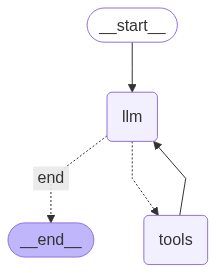

In [31]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [32]:
# Use the Runnable
final_state = app.invoke(
    {"messages": [HumanMessage(content="current weather in mumbai")]},
    config={"configurable": {"thread_id": 42}}
)

here is message from call model [HumanMessage(content='current weather in mumbai', additional_kwargs={}, response_metadata={}, id='965c3fb4-5e86-4abe-bb5a-153af931f29a')]


In [33]:
final_state["messages"][-1].content

'I do not have access to real-time information, including live weather updates.  To get the current weather in Mumbai, I recommend checking a reliable weather website or app such as Google Weather, AccuWeather, or another weather service you trust.'

'I do not have access to real-time information, including live weather updates.  To get the current weather in Mumbai, I recommend checking a reliable weather website or app such as Google Weather, AccuWeather, or another weather service specific to your region.'